In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE #for handeling imbalance in data
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
import warnings
warnings.filterwarnings('ignore')

In [73]:
df=pd.read_csv('/content/drive/MyDrive/Churn_Modelling.csv')

In [74]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [75]:
df.shape

(10000, 14)

### No duplicate rows

In [76]:
df.duplicated().sum()

0

### No missing values are present

In [77]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

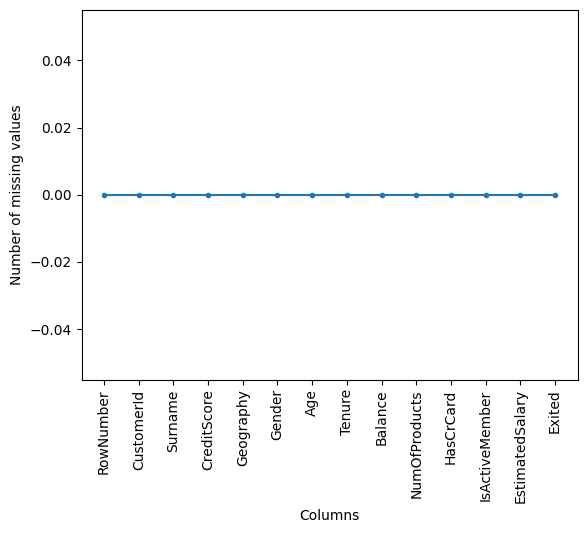

In [78]:
plt.plot(df.isnull().sum(),'.-')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Number of missing values')
plt.show()

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [80]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## Data Cleaning

### Data is imbalanced

In [81]:
df['Exited'].value_counts()/len(df['Exited'])*100

0    79.63
1    20.37
Name: Exited, dtype: float64

In [82]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

### Converting tenure to bins

In [83]:
df['Tenure'].nunique()

11

In [84]:
df['Tenure'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

In [85]:
labels=["{0} - {1}".format(i,i+2) for i in range(1,11,2)]
df['Tenure_grp']=pd.cut(df['Tenure'],range(1,12,2),right=False,labels=labels)

In [86]:
df['Tenure_grp'].value_counts()

1 - 3     2083
7 - 9     2053
3 - 5     1998
5 - 7     1979
9 - 11    1474
Name: Tenure_grp, dtype: int64

In [87]:
#similarly making age grp bins
labels=["{0} - {1}".format(i,i+5) for i in range(18,93,5)]
df['Age_grp']=pd.cut(df['Age'],range(18,94,5),right=False,labels=labels)

In [88]:
df['Age_grp'].value_counts()

33 - 38    2297
38 - 43    2019
28 - 33    1770
43 - 48    1184
23 - 28     794
48 - 53     670
53 - 58     385
58 - 63     296
18 - 23     226
63 - 68     167
68 - 73     107
73 - 78      61
78 - 83      17
83 - 88       4
88 - 93       3
Name: Age_grp, dtype: int64

### Removing irrelevant columns such as name and customerid

In [89]:
df.drop(['RowNumber','CustomerId','Surname','Tenure','Age'],inplace=True,axis=1)

In [90]:
df.head()

,CreditScore,Geography,Gender,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_grp,Age_grp
0,619,France,Female,0.00,1,1,1,101348.88,1,1 - 3,38 - 43
1,608,Spain,Female,83807.86,1,0,1,112542.58,0,1 - 3,38 - 43
2,502,France,Female,159660.80,3,1,0,113931.57,1,7 - 9,38 - 43
3,699,France,Female,0.00,2,0,0,93826.63,0,1 - 3,38 - 43
4,850,Spain,Female,125510.82,1,1,1,79084.10,0,1 - 3,43 - 48


## EDA

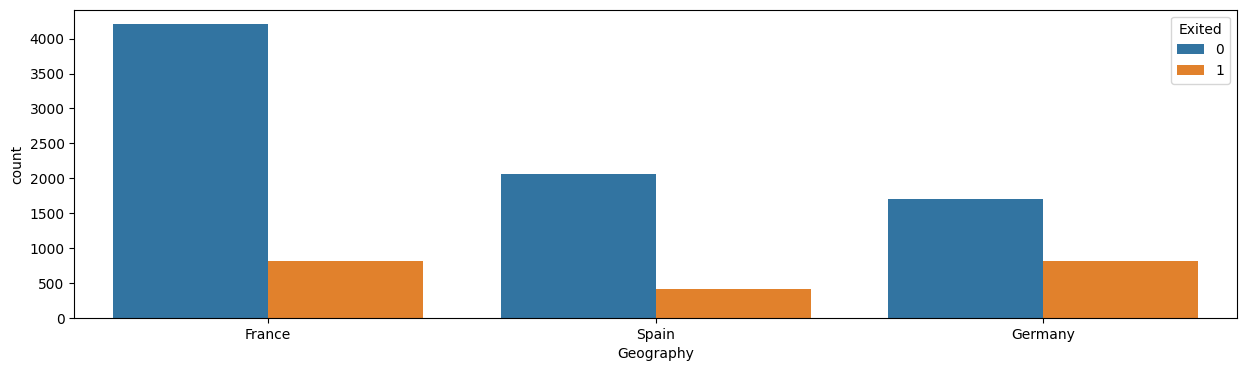

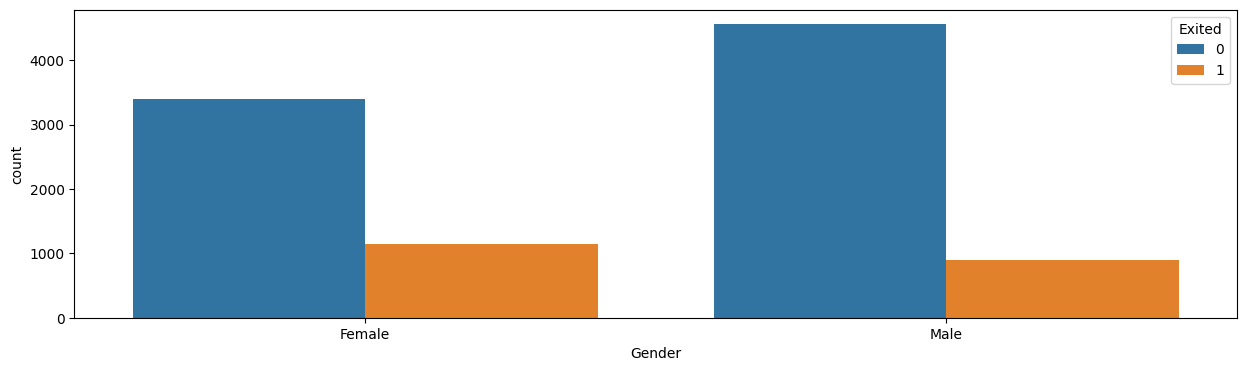

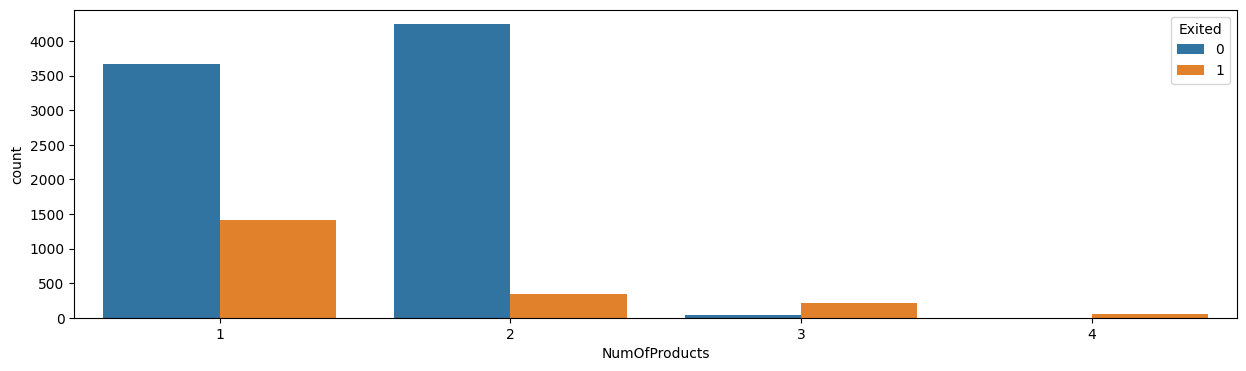

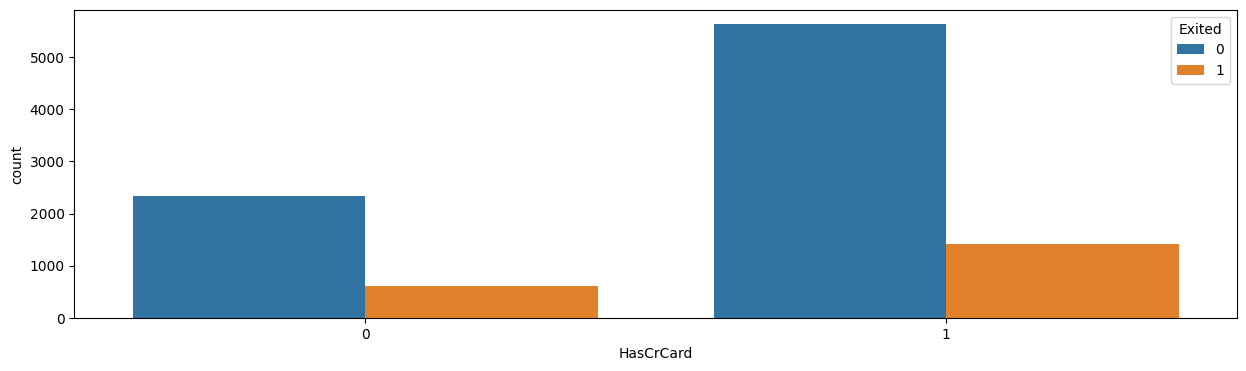

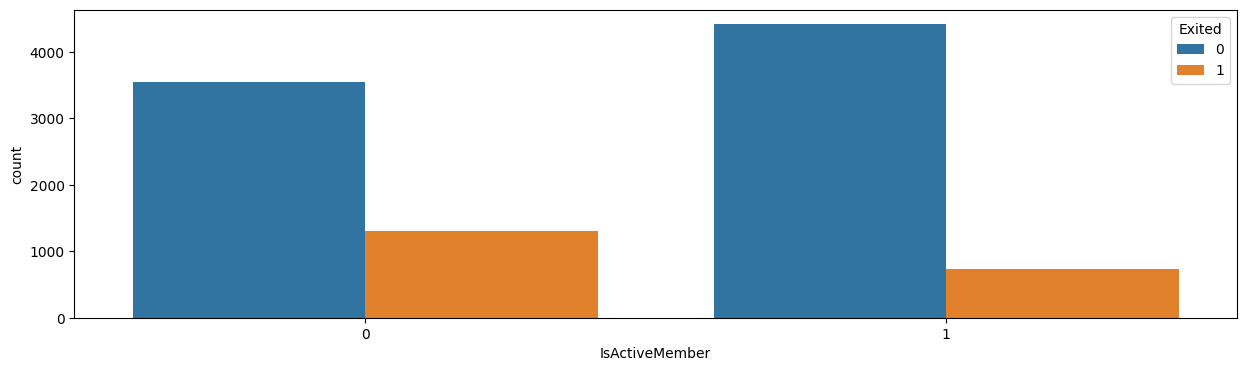

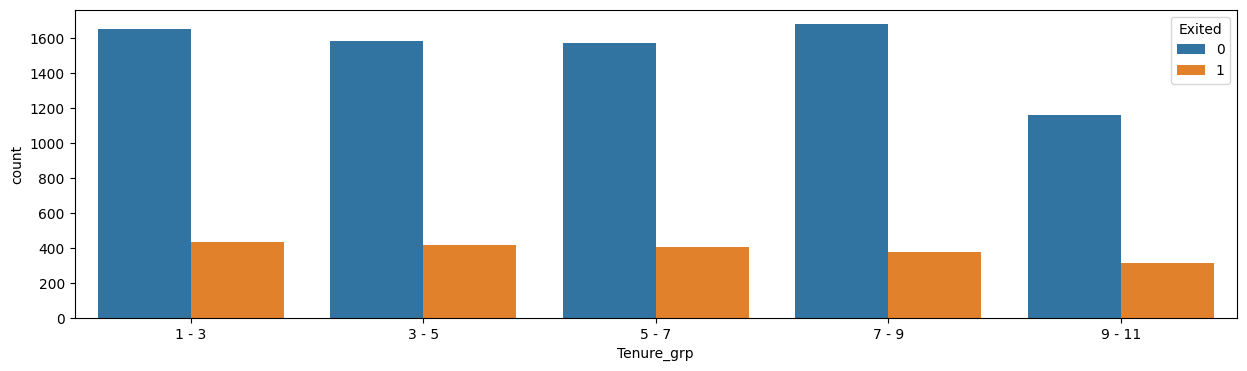

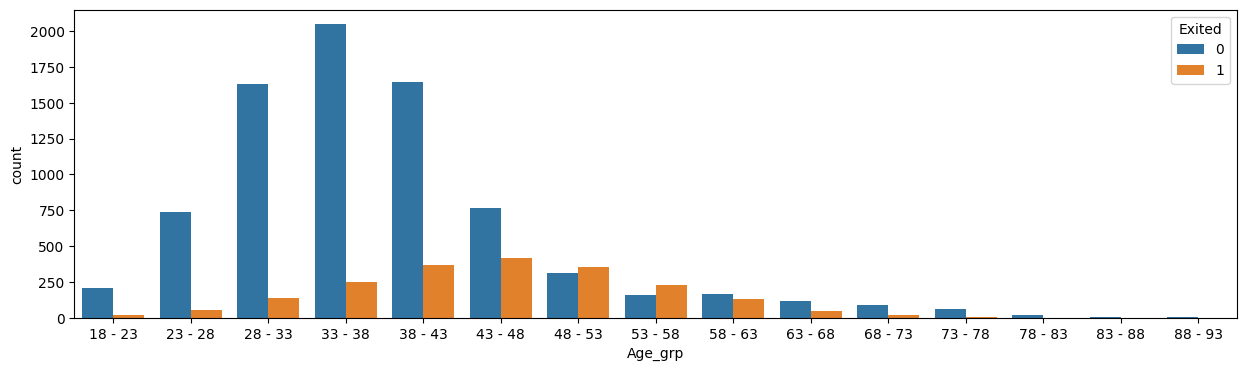

In [59]:
for idx , pred in enumerate(df.drop(columns=['Exited','Balance','EstimatedSalary','CreditScore'])):
    plt.figure(idx,figsize=(15,4))
    sns.countplot(data=df,x=pred,hue='Exited')

<Axes: xlabel='EstimatedSalary', ylabel='Density'>

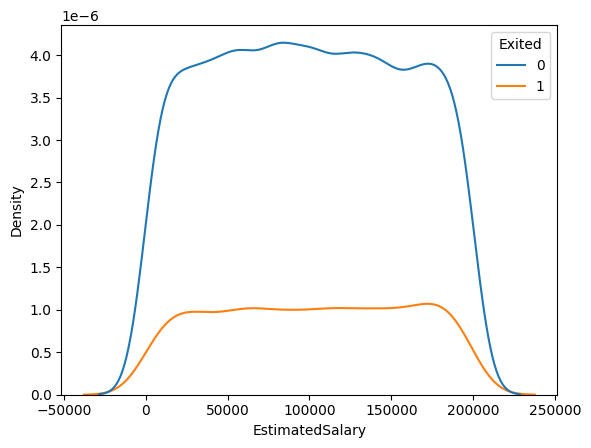

In [60]:
sns.kdeplot(x = df['EstimatedSalary'],hue=df['Exited'])

<Axes: xlabel='CreditScore', ylabel='Density'>

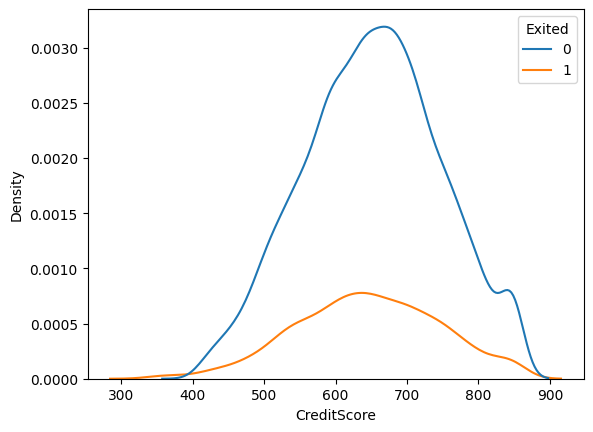

In [61]:
sns.kdeplot(x = df['CreditScore'],hue=df['Exited'])

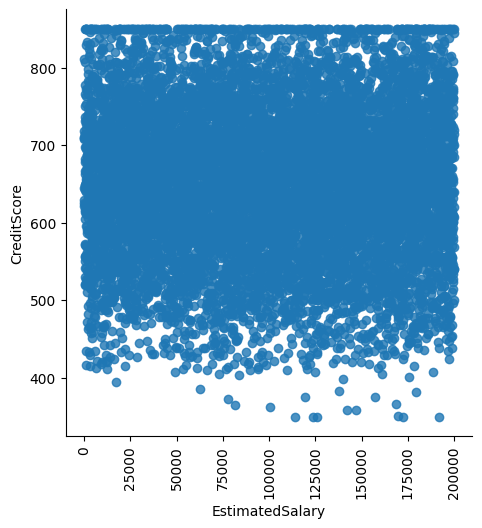

In [62]:
sns.lmplot(data=df,y='CreditScore',x='EstimatedSalary')
plt.xticks(rotation=90)
plt.show()

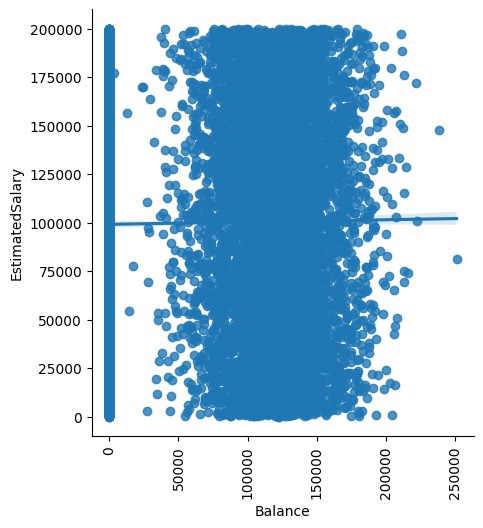

In [63]:
sns.lmplot(data=df,x='Balance',y='EstimatedSalary')
plt.xticks(rotation=90)
plt.show()

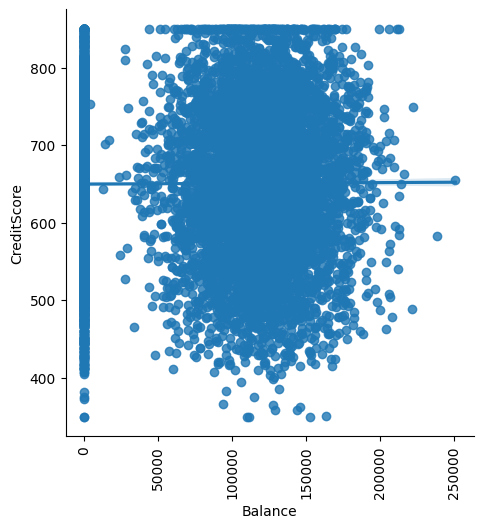

In [64]:
sns.lmplot(data=df,y='CreditScore',x='Balance')
plt.xticks(rotation=90)
plt.show()

Observation: No linear relation is present between CreditScore,ExtimatedSalar,Balance

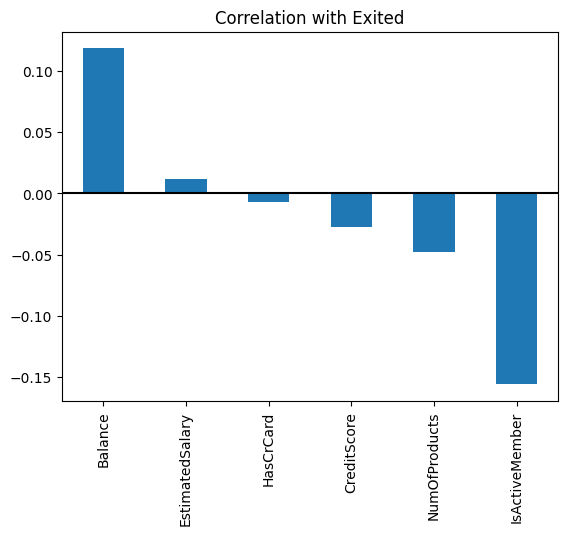

In [65]:
df.corr()['Exited'].sort_values(ascending=False)[1:].plot(kind='bar',title='Correlation with Exited')
plt.axhline(y = 0,color='black', linestyle = '-')

Obbservation: Exited have positive correlation only with Balance anf Estimated salary.So people having large balance are more likely to exit where have Active memebers are least likely to exit

<Axes: >

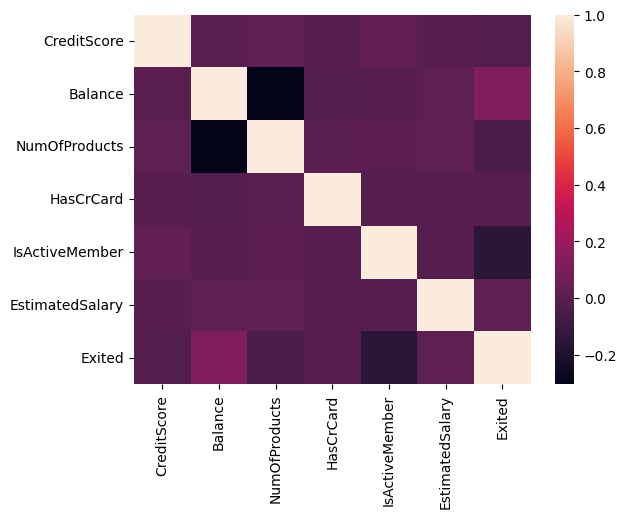

In [66]:
sns.heatmap(df.corr())

### Bivariate Analysis

In [67]:
df_exited = df[df['Exited']>0]

<Axes: xlabel='IsActiveMember', ylabel='count'>

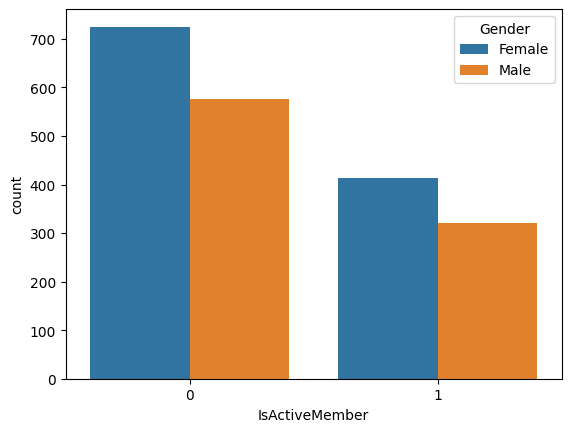

In [68]:
sns.countplot(x = df_exited['IsActiveMember'],hue=df_exited['Gender'])

<Axes: xlabel='HasCrCard', ylabel='count'>

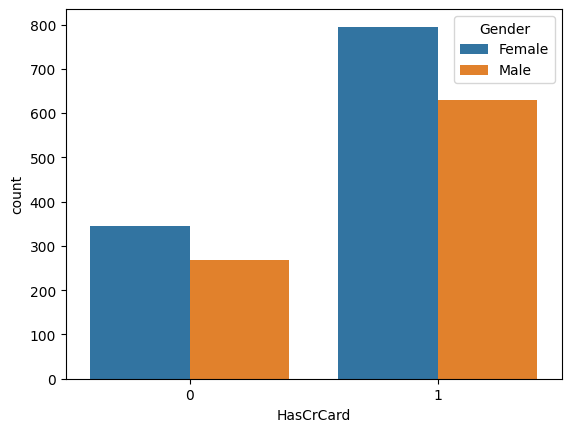

In [69]:
sns.countplot(x = df_exited['HasCrCard'],hue=df_exited['Gender'])

Observation: as in the previous case females are more likely to exit whether they have credit card or not. but it also shows that prople having credit card are more likey to exit

<Axes: xlabel='HasCrCard', ylabel='count'>

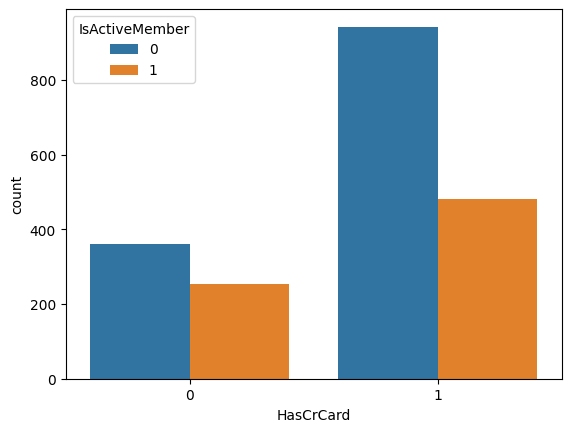

In [70]:
sns.countplot(x = df_exited['HasCrCard'],hue=df_exited['IsActiveMember'])

Observation: Customer having credit card are more active and also most likely to exit

## Model Traning

In [91]:
X=df.drop('Exited',axis=1)
Y=df['Exited']

In [92]:
# applying OneHotEncoding on nominal columns and scaling the numerical columns using columns transformer
ct=ColumnTransformer(
    [
        ('ohe',OneHotEncoder(sparse=False,drop='first'),['Geography','Gender','Tenure_grp','Age_grp']),
        ('sc',StandardScaler(),['CreditScore','Balance','EstimatedSalary',]),
    ],remainder='passthrough'
)

In [93]:
# applying changes to X
X_new = ct.fit_transform(X)

In [94]:
X_new

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 3., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 2., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [95]:
# balancing the data as its very imbalanced with the help of smote module
sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(X_new, Y)

### Train test split

In [96]:
x_train,x_test,y_train,y_test=train_test_split(X_res,Y_res,test_size=0.2,random_state=42)

In [97]:
x_train.shape

(12740, 28)

In [98]:
x_test.shape

(3186, 28)

### SVM Classifier

In [111]:
sv_classifier = SVC()
sv_classifier.fit(x_train, y_train)
y_pred = sv_classifier.predict(x_test)
accuracy = cross_val_score(sv_classifier,X_res,Y_res)

print("Validation Accuracy:", np.mean(accuracy)*100)
print(classification_report(y_test, y_pred))

Validation Accuracy: 82.39373988042269
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1633
           1       0.81      0.84      0.83      1553

    accuracy                           0.83      3186
   macro avg       0.83      0.83      0.83      3186
weighted avg       0.83      0.83      0.83      3186



### Logistic Regression Classifier

In [112]:
lr_classifier = LogisticRegression()
lr_classifier.fit(x_train, y_train)
y_pred = lr_classifier.predict(x_test)
accuracy = cross_val_score(lr_classifier,X_res,Y_res)

print("Validation Accuracy:", np.mean(accuracy)*100)
print(classification_report(y_test, y_pred))

Validation Accuracy: 73.54644781279165
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1633
           1       0.73      0.72      0.72      1553

    accuracy                           0.73      3186
   macro avg       0.73      0.73      0.73      3186
weighted avg       0.73      0.73      0.73      3186



### Random Forest Classifier

In [113]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_test)
accuracy = cross_val_score(rf_classifier,X_res,Y_res)

print("Validation Accuracy:", np.mean(accuracy)*100)
print(classification_report(y_test, y_pred))

Validation Accuracy: 91.17246272694214
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1633
           1       0.92      0.90      0.91      1553

    accuracy                           0.91      3186
   macro avg       0.91      0.91      0.91      3186
weighted avg       0.91      0.91      0.91      3186



### GradientBoosting Classifier

In [114]:
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(x_train, y_train)
y_pred = gb_classifier.predict(x_test)
accuracy = cross_val_score(gb_classifier,X_res,Y_res)

print("Validation Accuracy:", np.mean(accuracy)*100)
print(classification_report(y_test, y_pred))

Validation Accuracy: 87.19157499302777
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      1633
           1       0.89      0.86      0.88      1553

    accuracy                           0.88      3186
   macro avg       0.88      0.88      0.88      3186
weighted avg       0.88      0.88      0.88      3186



##### It can be observed that Randomforest provide the best accuracy

#### Random seach CV

In [130]:
distributions = dict(n_estimators=range(50,150,10),
                      criterion=['gini', 'entropy', 'log_loss'],
                     min_samples_split=range(0,6,2),
                     max_features=['sqrt', 'log2', None]
                    )
rs=RandomizedSearchCV(rf_classifier,distributions,random_state=42)

In [131]:
search = rs.fit(x_train,y_train)

In [132]:
search.best_params_

{'n_estimators': 120,
 'min_samples_split': 2,
 'max_features': 'log2',
 'criterion': 'entropy'}

In [133]:
rf_classifier = RandomForestClassifier(
    n_estimators = 120,
 min_samples_split= 2,
 max_features='log2',
 criterion='entropy'
)
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_test)
accuracy = cross_val_score(rf_classifier,X_res,Y_res)

print("Validation Accuracy:", np.mean(accuracy)*100)
print(classification_report(y_test, y_pred))

Validation Accuracy: 91.48643052759276
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1633
           1       0.92      0.90      0.91      1553

    accuracy                           0.91      3186
   macro avg       0.91      0.91      0.91      3186
weighted avg       0.91      0.91      0.91      3186



Not much imporvement in accuracy but still RandomForest provides the best accuracy so we choose it